# ImageGenetic AI

# Setting up Environment

## Importing Libraries

In [87]:
import os
import cv2
import time
import colour
import random
import threading
import numpy as np
import matplotlib.pyplot as plt

from helpers import fitness
from ImageObject import ImageObject

random.seed(time.time())

## Constants

In [88]:
NO_OF_POPULATIONS = 200 # Number of populations per image
NO_OF_OBJECTS_PER_POPULATION = 1000 # Number of objects per population
NO_OF_GENERATIONS_PER_POPULATION = 200 # Number of generations
NO_OF_PARENTS = 100 # Number of parents
NO_OF_CHILDREN = 10 # Number of children
SELECTION_TYPE = 'tournament' # Selection type
TOURNAMENT_SIZE = 5 # Tournament size
MUTATION_PROBABILITY = 0.1 # Mutation probability
CROSSOVER_PROBABILITY = 0.5 # Crossover probability
NO_OF_THREADS = 12 # Number of threads

PLOTS_FOLDER = 'plots' # Plots folder
RECORDS_FOLDER = 'records' # Records folder
SOURCE_IMAGE = 'source_images/crumble.jpg' # Source image
OUTPUT_IMAGE = 'output_images/' # Output image
SHAPES_FOLDERS = {
    "geom_dash": './shapes/geometry-dash-objects',
    "poke_badges": './shapes/pokeAPI/badges',
    "poke_berries": './shapes/pokeAPI/berries',
    "poke_dream": './shapes/pokeAPI/dream-world',
    "poke_items": './shapes/pokeAPI/items',
    "poke_pokemon": './shapes/pokeAPI/pokemon',
    "poke_underground": './shapes/pokeAPI/underground',

}


RECORDS = True # Record the output images
PLOTS = True # Plot the fitness graph
SAVE = True # Save the output image

MAX_WIDTH = 1920 # Maximum width of the input and output image

## Creating Folder Structure

In [89]:
# Creating the output folders
if RECORDS:
    if not os.path.exists(RECORDS_FOLDER):
        os.makedirs(RECORDS_FOLDER)
if PLOTS:
    if not os.path.exists(PLOTS_FOLDER):
        os.makedirs(PLOTS_FOLDER)
if SAVE:
    if not os.path.exists(OUTPUT_IMAGE):
        os.makedirs(OUTPUT_IMAGE)

# Create the sources folder
if not os.path.exists('source_images'):
    os.makedirs('source_images')

# Main Algorithm Setup

## Loading Source Image

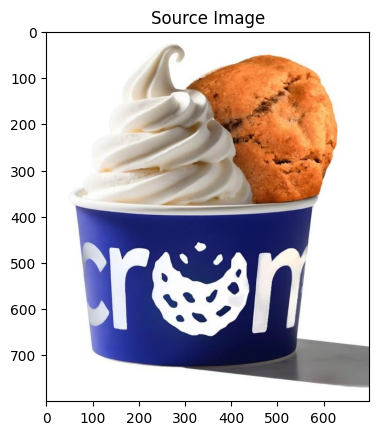

In [90]:
source_image = cv2.imread(SOURCE_IMAGE)

# Resize the image
height, width = source_image.shape[:2]
if width > MAX_WIDTH:
    source_image = cv2.resize(
        source_image, (MAX_WIDTH, int(height * MAX_WIDTH / width))
    )

plt.imshow(cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB))
plt.title('Source Image')
plt.show()

## Load Image Objects

In [91]:
for folder in SHAPES_FOLDERS:
    print(folder)

geom_dash
poke_badges
poke_berries
poke_dream
poke_items
poke_pokemon
poke_underground


Number of objects: 85


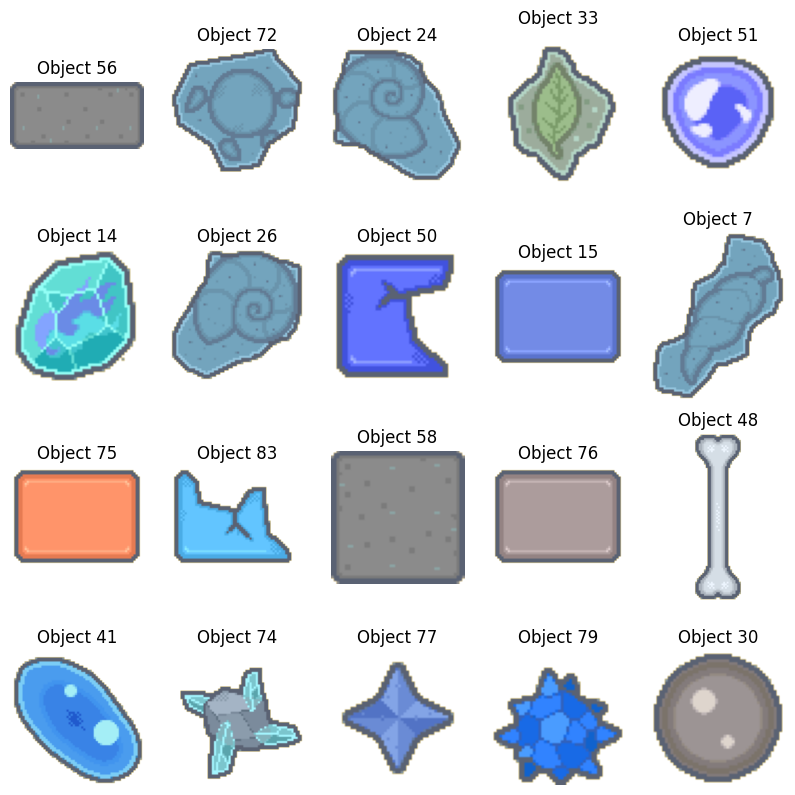

In [92]:
# Loading image objects
image_objects = []

with os.scandir(SHAPES_FOLDERS['poke_underground']) as entries:
    for entry in entries:
        if entry.is_file():
            image_objects.append(ImageObject(
                entry.path, 
                source_image.copy(),
                MAX_WIDTH,
                MUTATION_PROBABILITY
            ))

print(f'Number of objects: {len(image_objects)}')
plt.figure(figsize=(10, 10))
for i in range(20):
    object_index = random.randint(0, len(image_objects) - 1)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image_objects[object_index].get_image())
    plt.title(f'Object {object_index}')
    plt.axis('off')
plt.show()

image_objects = []

with os.scandir(SHAPES_FOLDERS['poke_underground']) as entries:
    for entry in entries:
        image_objects.append(entry.path)

## Initializing Empty Canvas

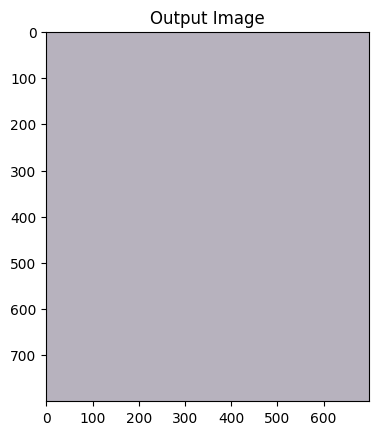

In [93]:
output_canvas = np.zeros_like(source_image, dtype=np.uint8)
output_canvas[:, :] = np.mean(source_image, axis=(0, 1))

plt.imshow(output_canvas)
plt.title('Output Image')
plt.show()

## Initializing Objects Population

In [94]:
# Initialize the population
population = []

random.seed(time.time())
for _ in range(NO_OF_OBJECTS_PER_POPULATION):
    population.append(
        ImageObject(
            random.choice(image_objects),
            source_image.copy(),
            MAX_WIDTH,
            MUTATION_PROBABILITY
        )
    )

# Evolutionary Process

## Single Threaded

In [ ]:
from concurrent.futures import ThreadPoolExecutor

# Evolutionary algorithm

last_fitness = float('inf')

for _ in range(NO_OF_POPULATIONS):
    print(f'Population: {_ + 1}')
    population_fitness = []

    for i in range(NO_OF_GENERATIONS_PER_POPULATION):
        print(f'Generation: {i + 1}', end='\r')
        random.seed(time.time())

        # Distribute over threads

        def calculate_fitness_for_individual(individual, canvas_copy):
            individual.calculate_fitness(canvas_copy)

        canvas_copies = [output_canvas.copy() for _ in range(NO_OF_THREADS)]
        with ThreadPoolExecutor(max_workers=NO_OF_THREADS) as executor:
            for idx, individual in enumerate(population):
                executor.submit(calculate_fitness_for_individual, individual, canvas_copies[idx % NO_OF_THREADS])

        # Sort the population based on fitness
        population.sort(key=lambda x: x.fitness, reverse=True)

        # Save the best individual
        if RECORDS:
            cv2.imwrite(
                f'{RECORDS_FOLDER}/population_{_ + 1}_generation_{i + 1}.png',
                population[0].get_image()
            )

        # Append the best fitness
        population_fitness.append(population[0].fitness)

        # Selection
        parents = []
        if SELECTION_TYPE == 'tournament':
            for _ in range(NO_OF_PARENTS):
                tournament = random.sample(population, TOURNAMENT_SIZE)
                parents.append(max(tournament, key=lambda x: x.fitness))
        else:
            parents = random.choices(
                population, k=NO_OF_PARENTS, weights=[x.fitness for x in population]
            )

        # Children generation
        children = []
        for _ in range(NO_OF_CHILDREN):
            child = random.choice(parents)
            children.append(child)

        # Mutation
        for child in children:
            child.mutate()

        # Replace the population
        population = parents + children

    # Save the best individual
    cv2.imwrite(
        f'{OUTPUT_IMAGE}/population_{_ + 1}.png', population[0].get_image()
    )

    if population[0].fitness <= last_fitness:
        output_canvas = population[0].render(output_canvas)
        last_fitness = population[0].fitness
        plt.imshow(output_canvas)
        plt.title(f'Output Image - Fitness: {last_fitness}')
        plt.show()

    # Plot the fitness graph
    if PLOTS:
        plt.plot(population_fitness)
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.title('Fitness Graph')
        plt.savefig(f'{PLOTS_FOLDER}/population_{_ + 1}.png')
        plt.close()

    # new population
    population = []

    random.seed(time.time())
    for _ in range(NO_OF_OBJECTS_PER_POPULATION):
        population.append(
            ImageObject(
                random.choice(image_objects),
                source_image.copy(),
                MAX_WIDTH,
                MUTATION_PROBABILITY
            )
        )

# Save the final output image
if SAVE:
    cv2.imwrite(f'{OUTPUT_IMAGE}/final_output.png', output_canvas)
    print('Final output image saved!')
    plt.imshow(output_canvas)
    plt.title('Final Output Image')
    plt.show()

Population: 1
